In [1]:
INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/BLA_LFP_data/LFP_BLA_gamma.mat'  # True In Vivo Data
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_background.mat'  # Pink Noise/Background
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_bg_like_sig.mat'  # Buried Gamma in BG
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/Generated/pn_multisine_gamma.npz'  # Generated Sine in PN
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine_syn_noise.mat'  # Synthetic Feng 1000 cell model Data
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'  # Feng Raw 1000 cell model Data

In [2]:
from lfp_prediction.data_gathering import MatlabCollector, NumpyCollector, TextCollector

frequency_band = (55, 85)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
    del data
    del labels
dc = MatlabCollector(INVIVO_RAW_PATH)
dc.get_data()
data, labels = dc.filter_data(filter_type='non-causal',
                              freq_band=frequency_band,
                              filter_rate=400)

data = data[:10000]

19176
(36544, 1, 300)
(36544, 1, 300)


In [3]:
from scipy.fft import rfft

data = rfft(data, axis=2).real
print(data.shape)

(10000, 1, 151)


In [4]:
class ComplexPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.u = self.s = self.components_ = None
        self.mean_ = None

    @property
    def explained_variance_ratio_(self):
        return self.s

    def fit(self, matrix, use_gpu=False):
        self.mean_ = matrix.mean(axis=0)
        if use_gpu:
            import tensorflow as tf  # torch doesn't handle complex values.
            tensor = tf.convert_to_tensor(matrix)
            u, s, vh = tf.linalg.svd(tensor, full_matrices=False)  # full=False ==> num_pc = min(N, M)
            # It would be faster if the SVD was truncated to only n_components instead of min(M, N)
        else:
            _, self.s, vh = np.linalg.svd(matrix, full_matrices=False)  # full=False ==> num_pc = min(N, M)
            # It would be faster if the SVD was truncated to only n_components instead of min(M, N)
        self.components_ = vh  # already conjugated.
        # Leave those components as rows of matrix so that it is compatible with Sklearn PCA.

    def transform(self, matrix):
        data = matrix - self.mean_
        result = data @ self.components_.T
        return result

    def inverse_transform(self, matrix):
        result = matrix @ np.conj(self.components_)
        return self.mean_ + result

In [5]:
from sklearn.decomposition import PCA
import numpy as np
np.set_printoptions(precision=3, suppress=True)

pca = PCA()

X_new = pca.fit_transform(np.squeeze(data))
print(X_new.shape)
print(pca.components_.shape)
print(pca.explained_variance_ratio_ * 100)

(10000, 151)
(151, 151)
[46.192 16.788 10.575  7.458  4.824  2.955  2.061  1.465  1.07   0.815
  0.608  0.492  0.403  0.327  0.28   0.273  0.268  0.258  0.255  0.24
  0.233  0.225  0.222  0.207  0.181  0.161  0.131  0.105  0.084  0.068
  0.055  0.044  0.037  0.032  0.028  0.025  0.022  0.02   0.018  0.016
  0.015  0.014  0.013  0.013  0.012  0.011  0.011  0.01   0.01   0.01
  0.01   0.009  0.009  0.009  0.008  0.008  0.008  0.008  0.008  0.008
  0.007  0.007  0.007  0.007  0.007  0.006  0.006  0.006  0.006  0.006
  0.006  0.006  0.006  0.005  0.005  0.005  0.005  0.005  0.005  0.005
  0.005  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.003  0.003  0.003  0.003  0.003  0.003  0.003
  0.003  0.003  0.003  0.003  0.003  0.003  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.001  0.001  0.001
  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.00

<IPython.core.display.Javascript object>


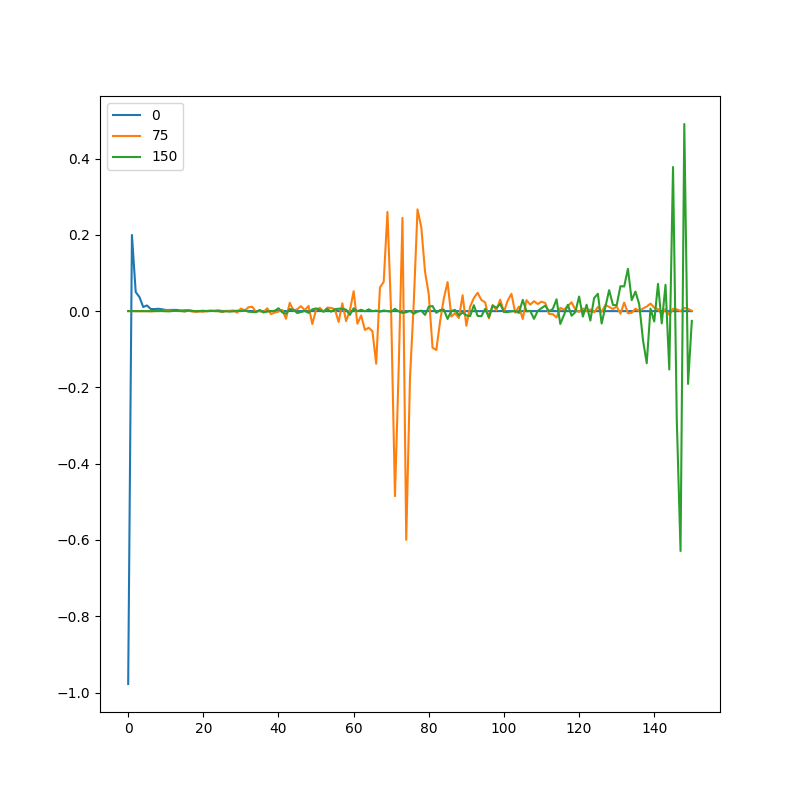

(151, 151)


In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

t = np.arange(pca.components_.shape[1])

components = [0, 75, 150]  # [0] + [i for i in range(299, 300)]

labels = list(map(str, components))
print(pca.components_.shape)

line_object = ax.plot(t, np.transpose(pca.components_[components, :]))
ax.legend(line_object, labels)
plt.show()

In [14]:
print(pca.noise_variance_)

0.0


In [15]:
# from sklearn.cluster import KMeans

# features = pca.components_[components, :]
# km = KMeans(n_clusters=8)
# labels = km.fit_predict(X_new)
# clustered = km.transform(X_new)

# print(labels.shape)

In [16]:
print(X_new.shape)
# print(clustered.shape)
features = pca.components_[components, :]
print(features.shape)

(10000, 151)
(3, 151)


<IPython.core.display.Javascript object>


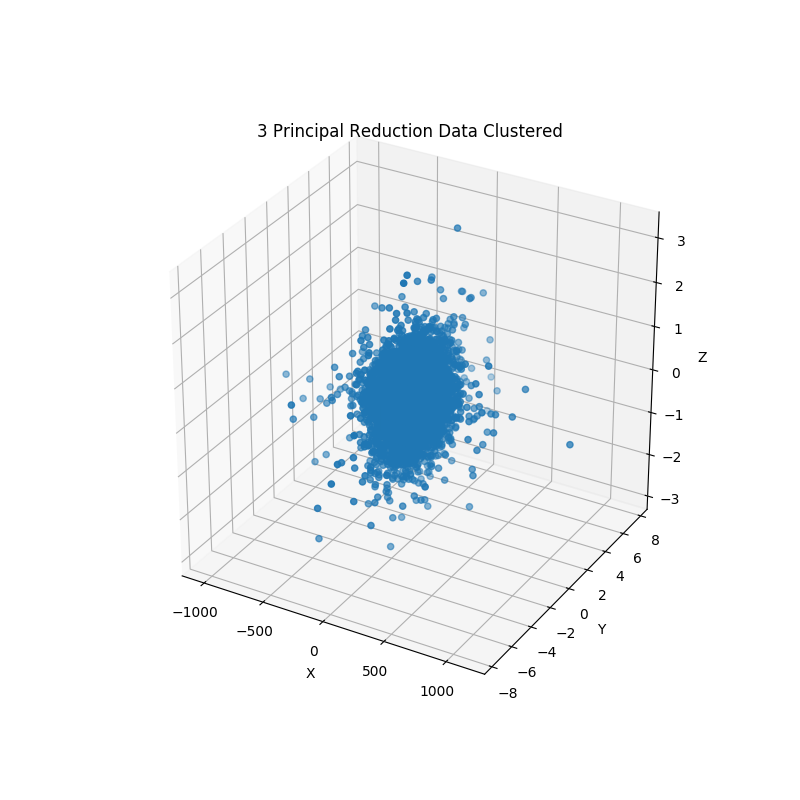

In [17]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_new[:,0], X_new[:,75], X_new[:,150])#, c=labels)
ax.set_title('3 Principal Reduction Data Clustered')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

<IPython.core.display.Javascript object>


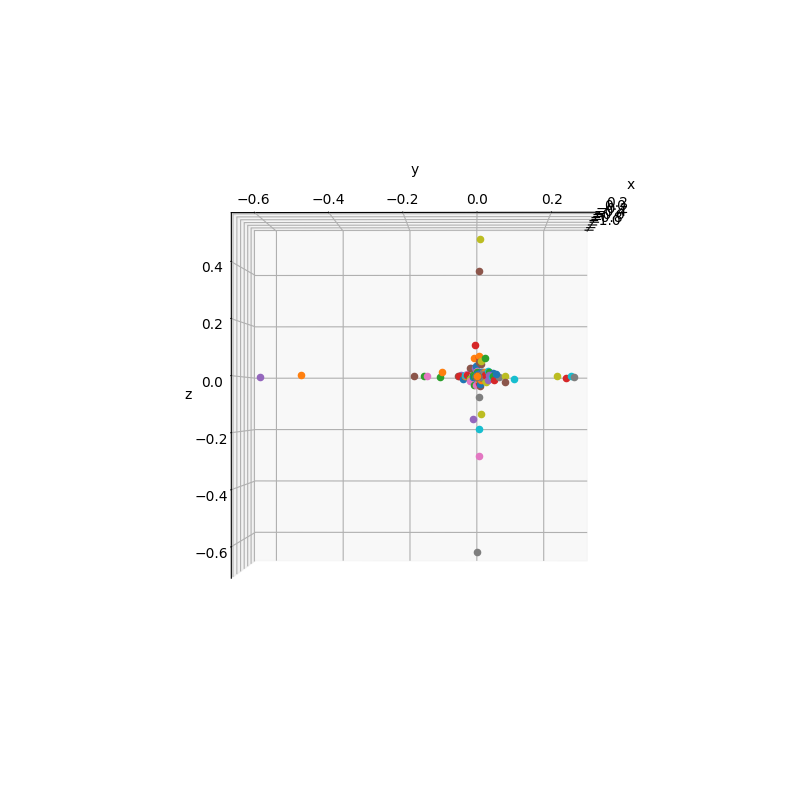

(151, 4)


In [19]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap('hsv')
colors = cmap(np.linspace(0, 1.0, features.shape[1]))
print(colors.shape)
num_eigenvec = features.shape[1]

for i in range(num_eigenvec):
    origin = [0,0,0]
    ax.scatter(features[0,i], 
              features[1,i], 
              features[2,i])
#     ax.quiver(*origin, 
#               features[0,i], 
#               features[1,i], 
#               features[2,i], 
#               length=0.05, 
#               normalize=True, 
#               pivot='tail', 
#               color=colors[i,:])

# ax.set_title('3 Principal Components')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()